# MoLora/Hermes2 13b - Basic Sampling Methods

[MoLora (Mixture of Loras)](https://crumbly.medium.com/llama-2-molora-f5f909434711) is a method that uses multiple low-ranked adapters (loras) finetuned on different datasets or chunks of datasets, then summed or otherwise combined afterward based on the distance of some text to each dataset or chunk. Here, the adapters are chosen again based on that distance where only the top-1 expert (lora) is chosen.

In this notebook we use top-1 per prompt, as well as top-1 per every n tokens, randomized with some temperature value. These adapters were finetuned from [Nous-Hermes-Llama2-13b](https://huggingface.co/NousResearch/Nous-Hermes-Llama2-13b) on a variety of internal datasets, at rank 32 in bf16 precision on query, key, value, and output projections.

This notebook can run on the free-tier of Google Colab (albeit slowly)!

In [1]:
!pip install -q -U transformers datasets sentence-transformers peft
!pip install -q -U bitsandbytes
!pip install -q -U accelerate

In [2]:
#@markdown Log into HuggingFace
from huggingface_hub import notebook_login, login
huggingface_token = "hf_.." #@param {type: "string"}
login(token=huggingface_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
#@markdown download the embedding model, hermes, the experts, and average embeddings for each dataset the experts were trained on
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from huggingface_hub import hf_hub_download, snapshot_download
import datetime

embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embedding_model = embedding_model.cuda()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

text_model = AutoModelForCausalLM.from_pretrained(
    snapshot_download("crumb/hermes2-bf16-shard"), quantization_config=bnb_config, low_cpu_mem_usage=True
)
tokenizer = AutoTokenizer.from_pretrained("crumb/hermes2-bf16-shard")
adapters_folder = snapshot_download("NousResearch/MoLora-Hermes-2-test")
centers = torch.load(adapters_folder + "/bio-chem-math-physics-cambridge.pt")
centers = centers.cuda()

Fetching 35 files:   0%|          | 0/35 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/26 [00:00<?, ?it/s]

Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
#@markdown as a control we'll run the base model (hermes 2) before use of experts, so we can note how the response changes
prompt = "What are the common techniques used in identifying a new species, and how can scientists accurately categorize it within the existing taxonomy system?" # we want a clean prompt going into the embedder
prompt = "### instruction:\n" + prompt + "\n### output:"
torch.manual_seed(0)
inputs = {k:v.cuda() for k,v in tokenizer(prompt, return_tensors="pt").items()}
outputs = text_model.generate(
    **inputs,
    max_new_tokens = 128,
    temperature = 0.7,
    top_k = 40,
    top_p = 0.9,
    do_sample=False
)
print(tokenizer.decode(outputs[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s> ### instruction:
What are the common techniques used in identifying a new species, and how can scientists accurately categorize it within the existing taxonomy system?
### output:
 Identifying a new species and categorizing it within the existing taxonomy system involves several common techniques. These include:
1. Morphological analysis: This involves examining the physical characteristics of an organism, such as size, shape, color, and structure. By comparing these traits with those of known species, scientists can determine if the organism is a new species or a variant of an existing one.
2. Genetic analysis: DNA sequencing and comparison can help identify a new species by comparing its genetic makeup with that of known species. This can reveal differences in genetic sequences that indicate


In [5]:
#@markdown we just load a dummy peft config to make it a PeftModel, then load each of the expert adapters
from peft import LoraConfig, get_peft_model
config = LoraConfig(r=32,lora_alpha=0,target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],lora_dropout=0.0,bias="none",task_type="CAUSAL_LM")
text_model = get_peft_model(text_model, config)

adapter_names = ["hermes-bio-adapter", "hermes-chem-adapter", "math-adapter/hermes-math-adapter", "physics-adapter/hermes-physics-adapter", "hermes-cambridge-adapter"]
for i in adapter_names:
    text_model.load_adapter(f"{adapters_folder}/{i}", adapter_name=f"{i}")

## Per-Prompt Adapter Sampling
here we choose the best adapter for the prompt, and stick with it throughout generation

In [7]:
#@markdown embed prompt and determine best adapter
prompt = "What are the common techniques used in identifying a new species, and how can scientists accurately categorize it within the existing taxonomy system?" # we want a clean prompt going into the embedder
prompt_embedding = torch.tensor(embedding_model.encode([prompt]), device='cuda')
prompt = "### instruction:\n" + prompt + "\n### output:"

expert_alphas = torch.softmax(
    torch.nn.functional.cosine_similarity(prompt_embedding,centers) * 1, -1
).tolist()
print("Probability for each expert:")
for i in zip(adapter_names, expert_alphas):
    print(f"{i[0]}: {i[1]}")

topk = torch.topk(torch.tensor(expert_alphas), 1)
top_adapter = adapter_names[topk.indices.item()]
print(f"\nChose: {top_adapter}")
text_model.set_adapter(top_adapter)

Probability for each expert:
hermes-bio-adapter: 0.25589436292648315
hermes-chem-adapter: 0.18646378815174103
math-adapter/hermes-math-adapter: 0.1748484969139099
physics-adapter/hermes-physics-adapter: 0.18990157544612885
hermes-cambridge-adapter: 0.19289182126522064

Chose: hermes-bio-adapter


In [8]:
#@markdown sample from top-1-adapter per prompt
torch.manual_seed(0)
inputs = {k:v.cuda() for k,v in tokenizer(prompt, return_tensors="pt").items()}
outputs = text_model.generate(
    **inputs,
    max_new_tokens = 128,
    temperature = 0.7,
    top_k = 40,
    top_p = 0.9,
    do_sample=False
)
print(tokenizer.decode(outputs[0]))

<s> ### instruction:
What are the common techniques used in identifying a new species, and how can scientists accurately categorize it within the existing taxonomy system?
### output:
There are several common techniques used in identifying a new species, and scientists can accurately categorize it within the existing taxonomy system by using a combination of these methods. Some of the key techniques include:
1. Morphological analysis: This involves examining the physical characteristics of an organism, such as size, shape, color, and structure. Scientists compare these features with those of known species to determine if the organism is a new species or a variant of an existing one.
2. Molecular analysis: This involves analyzing the genetic material (DNA or RNA) of an


## Per-N-Token Adapter Sampling
we can also change the adapter per-token, instead of per-prompt! with a little bit of overhead of course from decoding/embedding the text and switching adapters

In [9]:
#@markdown create a function we'll use to switch out the adapter dynamically per n tokens
def choose_adapter(context, temperature=1., do_sample=False):
    prompt_embedding = torch.tensor(embedding_model.encode([context]), device='cuda')
    expert_alphas = torch.softmax(torch.nn.functional.cosine_similarity(prompt_embedding,centers) / temperature, -1)
    if do_sample:
        idx = expert_alphas.multinomial(1).item()
    else:
        idx = torch.topk(torch.tensor(expert_alphas), 1).item()
    chosen_adapter = adapter_names[idx]
    text_model.set_adapter(chosen_adapter)
    return chosen_adapter

In [10]:
#@markdown introduce some randomness and choose an adapter every n tokens to sample from
from tqdm.notebook import trange
torch.manual_seed(0)

prompt = "What are the common techniques used in identifying a new species, and how can scientists accurately categorize it within the existing taxonomy system?"
prompt = "### instruction:\n" + prompt + "\n### output:"
switch_per_n_tokens = 1
max_new_tokens = 128

# higher temp = more randomness
adapter_sampling = True
adapter_temperature = 0.3

inputs = {k:v.cuda() for k,v in tokenizer(prompt, return_tensors="pt").items()}
input_ids = inputs['input_ids']
adapter_history = []

for i in trange(max_new_tokens // switch_per_n_tokens):
    adapter = choose_adapter(tokenizer.decode(input_ids[0]), adapter_temperature, adapter_sampling)
    adapter_history.append(adapter)
    input_ids = text_model.generate(
        input_ids = input_ids,
        max_new_tokens = switch_per_n_tokens,
        temperature = 0.7,
        top_k = 40,
        top_p = 0.9,
        do_sample=False
    )

print(tokenizer.decode(input_ids[0]))

  0%|          | 0/128 [00:00<?, ?it/s]

<s> ### instruction:
What are the common techniques used in identifying a new species, and how can scientists accurately categorize it within the existing taxonomy system?
### output:
There are several common techniques used in identifying a new species, and scientists can accurately categorize it within the existing taxonomy system by following these steps:
1. Morphological analysis: This involves examining the physical characteristics of an organism, such as size, shape, color, and structure. Scientists compare these features to those of known species to determine if the organism is a new species or a variation of an existing one.

2. Molecular analysis: This involves analyzing the genetic material (DNA or RNA) of an organism. By comparing the genetic sequences


In [11]:
#@markdown we can look at the journey it took
print(adapter_history)

['hermes-cambridge-adapter', 'hermes-bio-adapter', 'math-adapter/hermes-math-adapter', 'hermes-bio-adapter', 'hermes-bio-adapter', 'math-adapter/hermes-math-adapter', 'hermes-bio-adapter', 'hermes-bio-adapter', 'hermes-chem-adapter', 'hermes-bio-adapter', 'math-adapter/hermes-math-adapter', 'hermes-bio-adapter', 'physics-adapter/hermes-physics-adapter', 'hermes-bio-adapter', 'hermes-chem-adapter', 'physics-adapter/hermes-physics-adapter', 'math-adapter/hermes-math-adapter', 'math-adapter/hermes-math-adapter', 'hermes-chem-adapter', 'hermes-bio-adapter', 'hermes-chem-adapter', 'hermes-cambridge-adapter', 'math-adapter/hermes-math-adapter', 'hermes-cambridge-adapter', 'hermes-cambridge-adapter', 'hermes-chem-adapter', 'hermes-bio-adapter', 'hermes-bio-adapter', 'hermes-cambridge-adapter', 'math-adapter/hermes-math-adapter', 'math-adapter/hermes-math-adapter', 'hermes-bio-adapter', 'physics-adapter/hermes-physics-adapter', 'hermes-bio-adapter', 'hermes-bio-adapter', 'hermes-bio-adapter', 

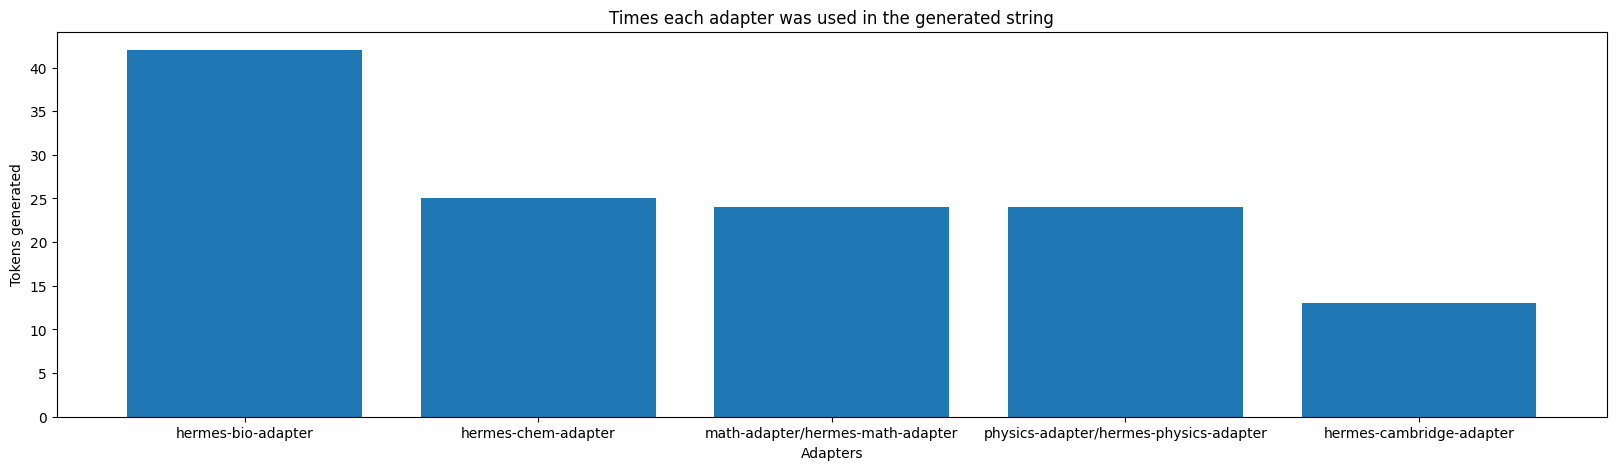

In [13]:
#@markdown we can also plot how many times each adapter was used
import matplotlib.pyplot as plt

counts = {}
for s in adapter_names:
    counts[s] = adapter_history.count(s)

keys = list(counts.keys())
values = list(counts.values())
values = [i * switch_per_n_tokens for i in values]

plt.figure(figsize=(20,5))

plt.bar(keys, values)
plt.xlabel("Adapters")
plt.ylabel("Tokens generated")
plt.title("Times each adapter was used in the generated string")
plt.show()